In [1]:
from ast import literal_eval

import numpy as np
import corner

import matplotlib.pyplot as plt
pltparams = {"axes.grid": False,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
        "axes.labelsize": 24,
        "legend.fontsize": 24,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(pltparams)

default_corner_kwargs = dict(bins=40, 
                        smooth=True, 
                        label_kwargs=dict(fontsize=16),
                        title_kwargs=dict(fontsize=16), 
                        quantiles=[],
                        levels=[0.68, 0.95],
                        plot_density=False, 
                        plot_datapoints=False, 
                        fill_contours=False,
                        max_n_ticks=4, 
                        min_n_ticks=3,
                        save=False,
                        truth_color="darkorange")


import pandas as pd

from fiesta.plot import latex_labels
from fiesta.plot import LightcurvePlotter
from fiesta.plot import corner_plot



## Posteriors

Load the data

In [2]:
posterior_afgpy = pd.DataFrame(dict(np.load("./afgpy/posterior.npz")))
posterior_pbag = pd.DataFrame(dict(np.load("./pbag/posterior.npz")))

/tmp/ipykernel_36237/3718351944.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


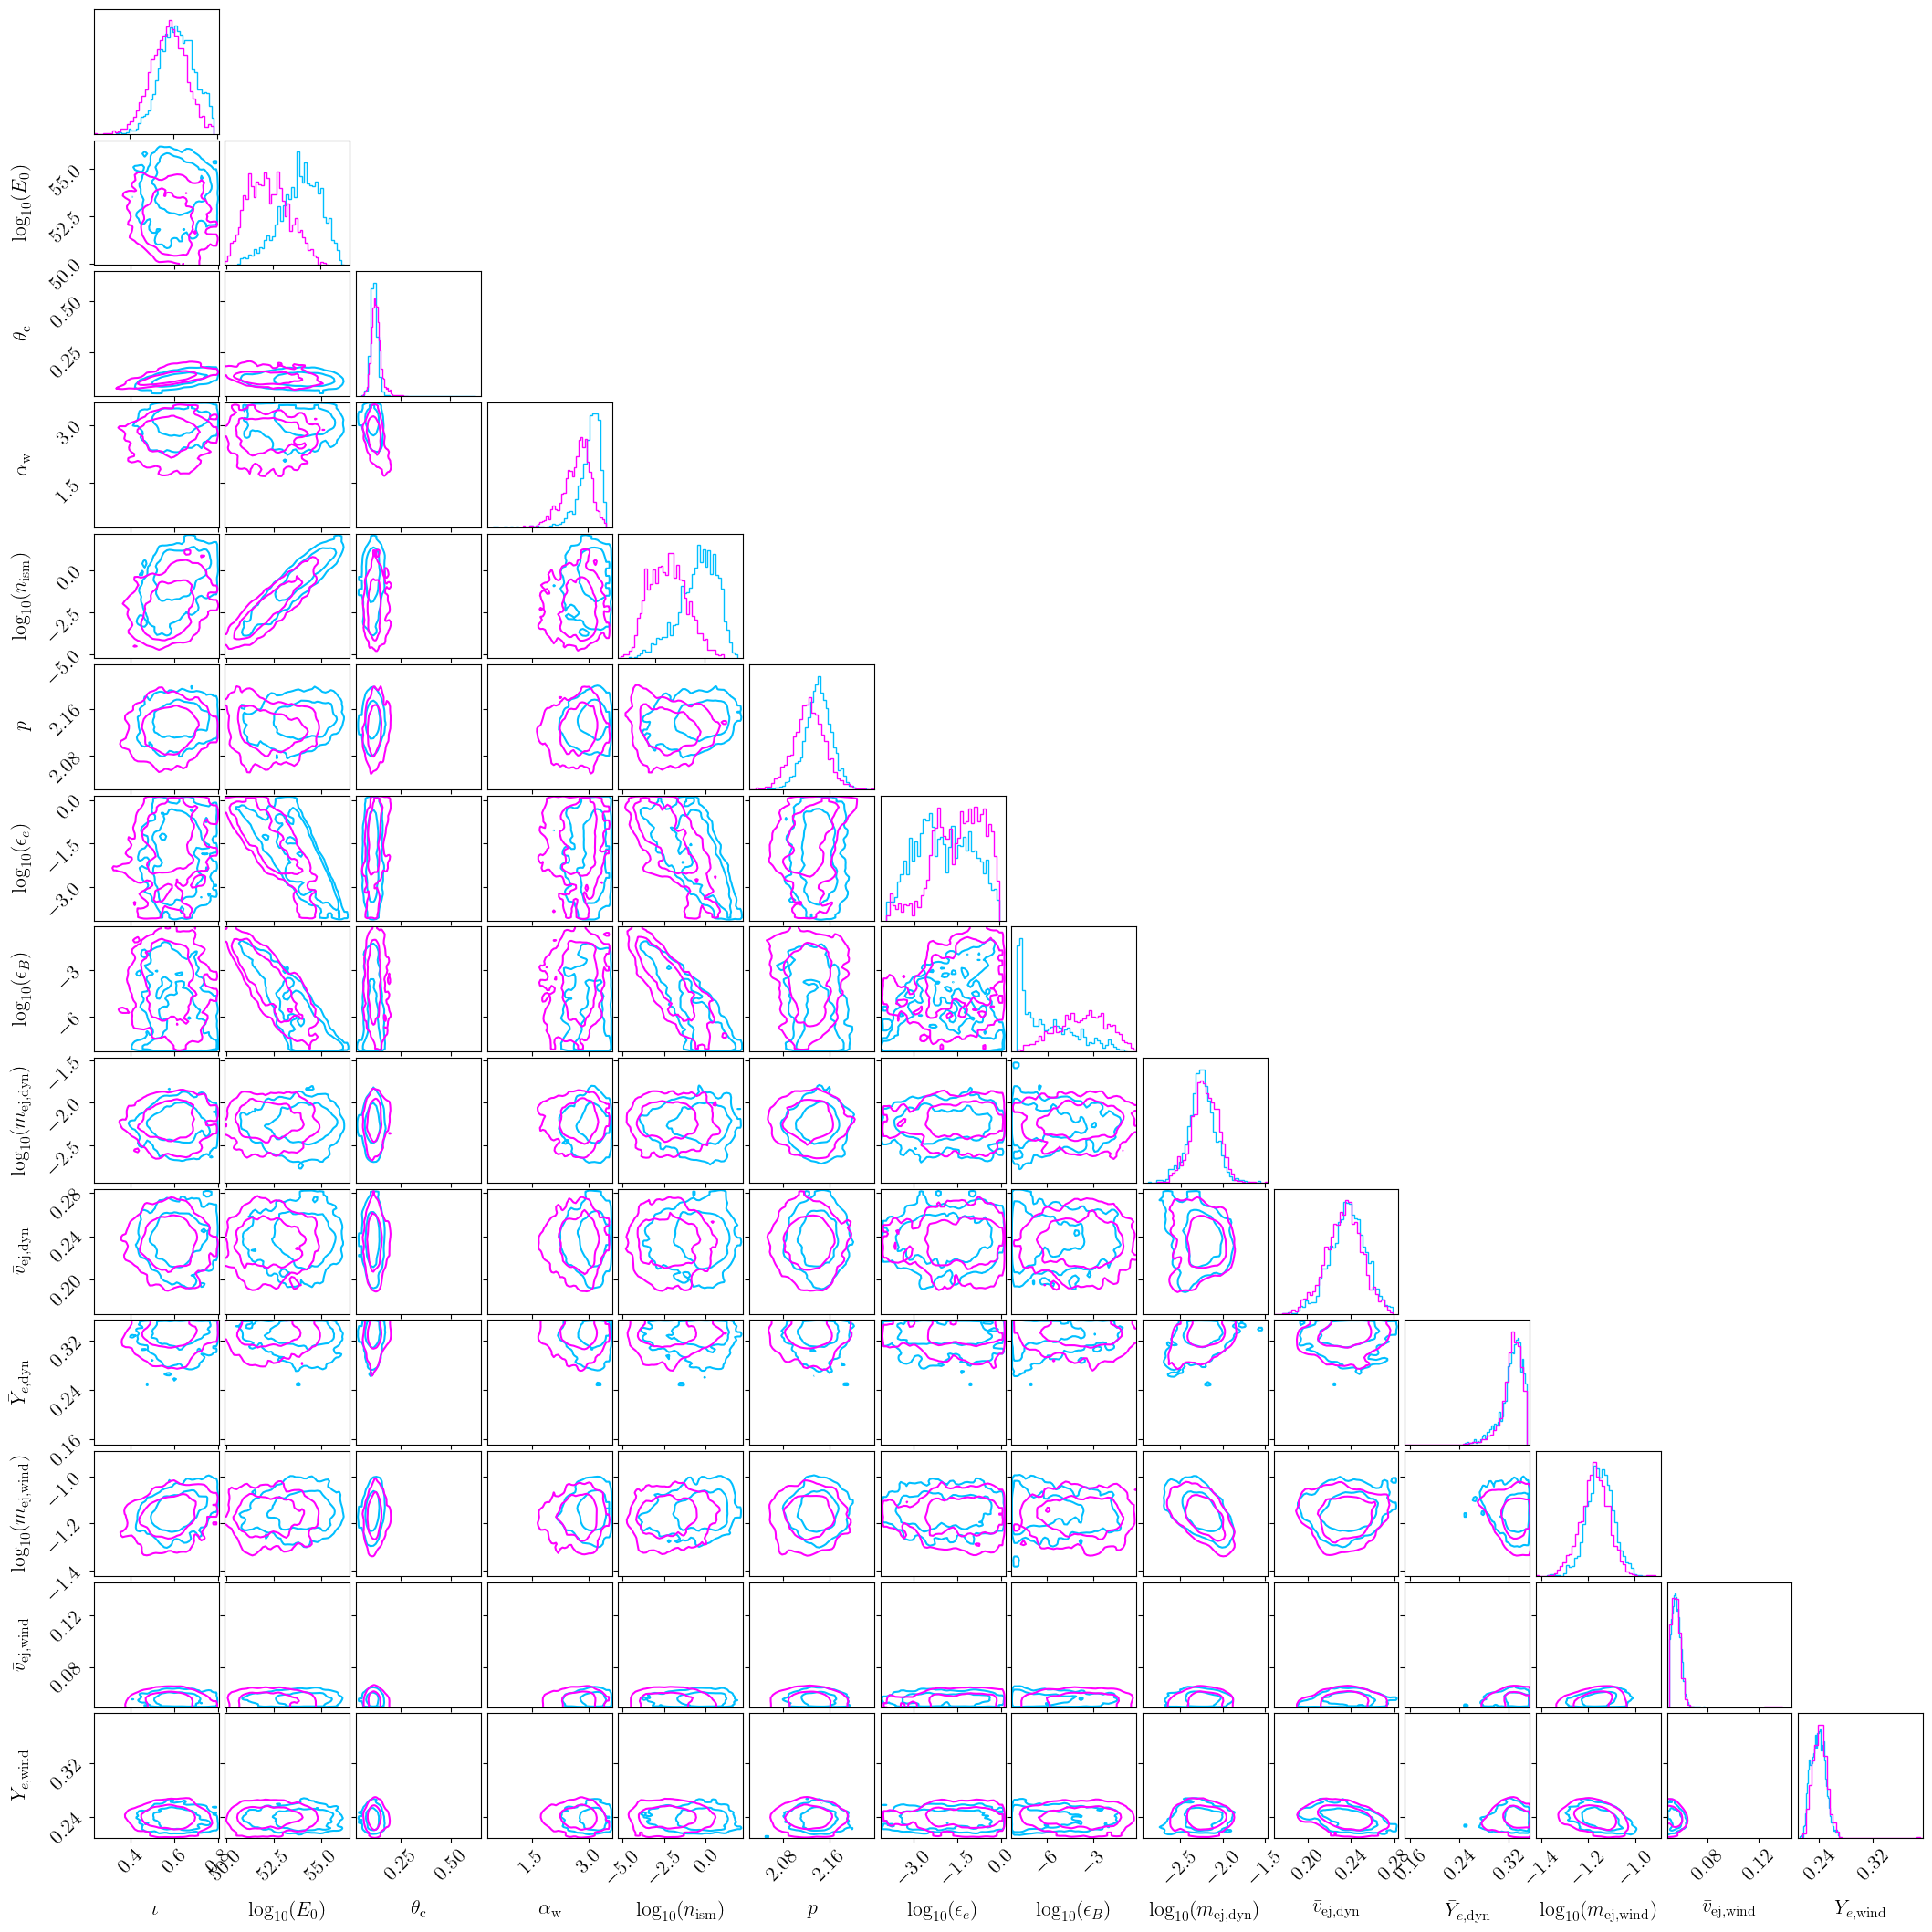

In [5]:
var_names = ['inclination_EM', 'log10_E0', 'thetaCore', 'alphaWing', 'log10_n0', 'p',
       'log10_epsilon_e', 'log10_epsilon_B', 'log10_mej_dyn', 'v_ej_dyn',
       'Ye_dyn', 'log10_mej_wind', 'v_ej_wind', 'Ye_wind']


fig, ax = corner_plot(posterior_afgpy, var_names, color="deepskyblue")
fig, ax = corner_plot(posterior_pbag, var_names, fig=fig, ax=ax, color="magenta")

fig.show()

Make corner plot

In [14]:
var_names = ["inclination_EM", "log10_E0", "thetaCore", "log10_mej_dyn", "log10_mej_wind", "Ye_dyn"]
labels = [latex_labels.get(p, p) for p in var_names]

rs = [(0.3, 0.82), (49.8, 57), (0, 0.25), (-2.8, -1.5), (-1.4, -0.9), (0.24, 0.35)]

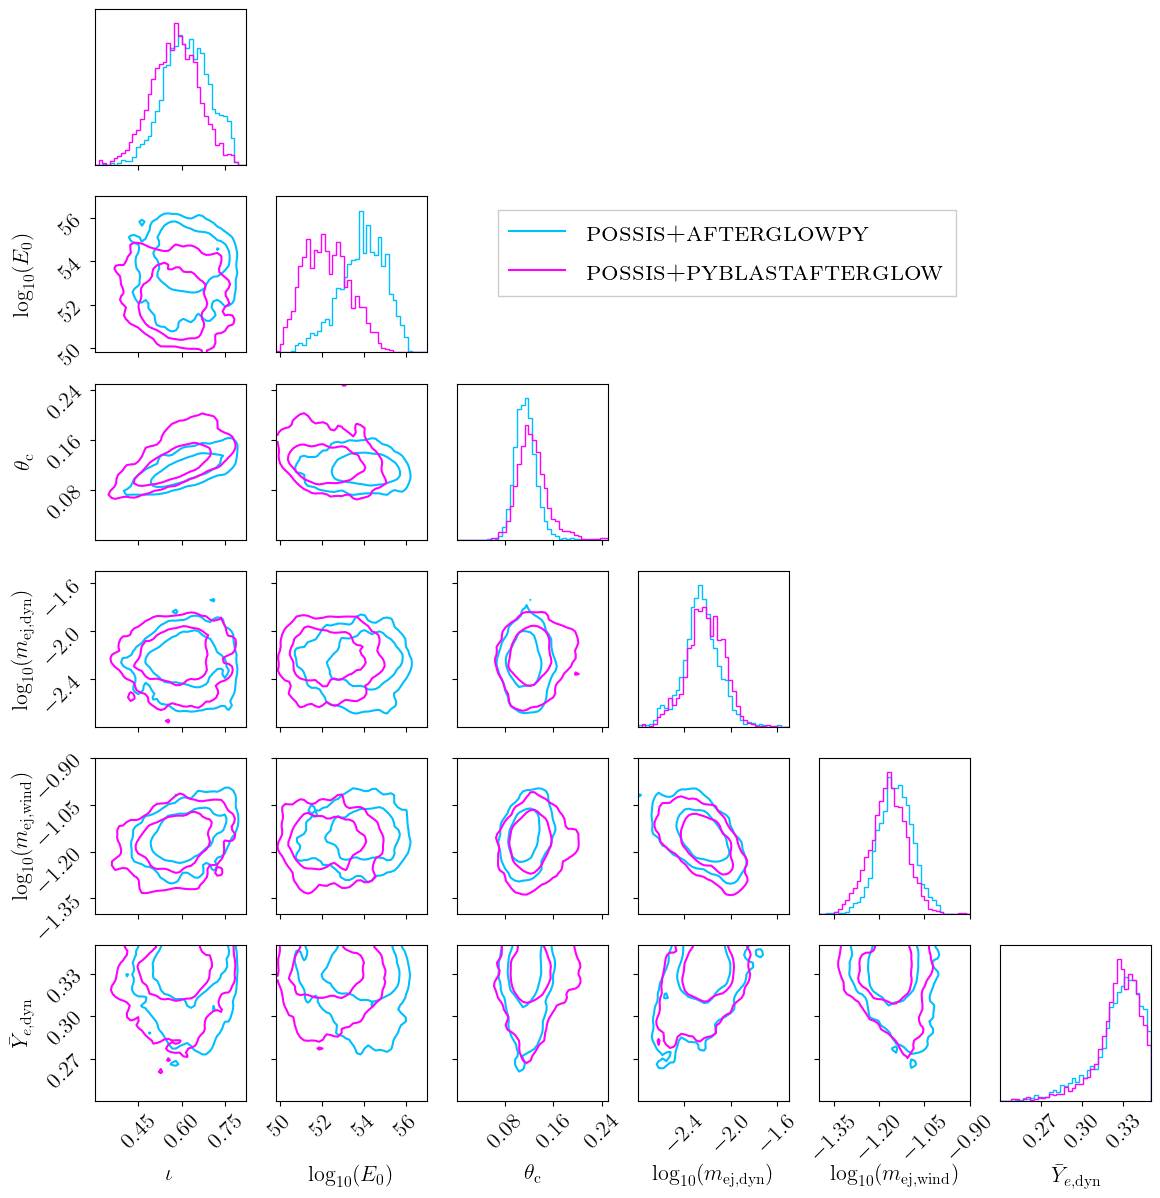

In [15]:
fig, ax = plt.subplots(len(var_names), len(var_names), figsize = (12, 12))

corner.corner(posterior_afgpy[var_names], 
              fig=fig,
              color = "deepskyblue",
             labelpad = 0.1,
              labels=labels,
              **default_corner_kwargs,
              hist_kwargs=dict(density=True),
              range=rs)

corner.corner(posterior_pbag[var_names],
              fig=fig,
              color="magenta",
              labelpad = 0.1,
              labels=labels,
              **default_corner_kwargs,
              hist_kwargs=dict(density=True),
              range=rs)

for j in range(5):
    max_y = max(p.get_path().vertices[:, 1].max() for p in ax[j,j].patches)
    ax[j,j].set_ylim(0, 1.1*max_y)

handles = []
for c in ["deepskyblue", "magenta"]:
    handle = plt.plot([],[], color=c)[0]
    handles.append(handle)

ax[1, 4].legend(handles=handles, labels=["\\textsc{possis}+\\textsc{afterglowpy}", "\\textsc{possis}+\\textsc{pyblastafterglow}"], fontsize=20, fancybox=False, framealpha=1)
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.96, top=0.99, hspace=0.2, wspace=0.2)
fig.savefig("posterior_GRB170817A.pdf", dpi=250)

In [54]:
low, median, high  = corner.quantile(posterior_pbag["log10_n0"], [0.025, 0.5, 0.975])

print(np.array([median-low, median, high-median]))

[ 1.90510869 -2.24517179  2.33316541]


In [55]:
low, median, high  = corner.quantile(posterior_afgpy["log10_n0"], [0.025, 0.5, 0.975])

print(np.array([median-low, median, high-median]))

[ 2.86141592 -0.2900421   1.64033026]


## Lightcurves

In [3]:
pltparams = {"axes.grid": False,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(pltparams)

In [4]:
from fiesta.inference.lightcurve_model import AfterglowFlux, BullaFlux, CombinedSurrogate
from fiesta.utils import load_event_data
from fiesta.inference.likelihood import EMLikelihood

data = load_event_data("../../data/AT2017gfo+GRB170817A_reduced.dat")
trigger_time = 57982.52851852

model_afgpy = AfterglowFlux(name="afgpy_gaussian_CVAE",
                      filters = data.keys())

model_pbag = AfterglowFlux(name="pbag_gaussian_CVAE",
                           filters=data.keys())

model2 = BullaFlux(name="Bu2025_MLP",
                   filters = data.keys())

model_afgpy = CombinedSurrogate(models=[model_afgpy, model2],
                          sample_times=np.geomspace(0.3, 1000, 200))

model_pbag = CombinedSurrogate(models=[model_pbag, model2],
                               sample_times=np.geomspace(0.3, 1000, 200))

12:21 fiesta INFO    : Loading surrogate afgpy_gaussian_CVAE. This surrogate should only be used in the following parameter ranges:
12:21 fiesta INFO    : 	 inclination_EM: (0, 1.5707963267948966)
12:21 fiesta INFO    : 	 log10_E0: (47, 57)
12:21 fiesta INFO    : 	 thetaCore: (0.01, 0.6283185307179586)
12:21 fiesta INFO    : 	 alphaWing: (0.2, 3.5)
12:21 fiesta INFO    : 	 log10_n0: (-6, 2)
12:21 fiesta INFO    : 	 p: (2.01, 3)
12:21 fiesta INFO    : 	 log10_epsilon_e: (-4, 0)
12:21 fiesta INFO    : 	 log10_epsilon_B: (-8, 0)


12:21 fiesta INFO    : Surrogate afgpy_gaussian_CVAE is loading with the following filters: ['2massh', '2massj', '2massks', 'X-ray-1keV', 'bessellv', 'ps1::g', 'ps1::i', 'ps1::r', 'ps1::y', 'ps1::z', 'radio-3GHz', 'radio-6GHz', 'sdssu'].
12:21 fiesta INFO    : Loaded for surrogate afgpy_gaussian_CVAE from /nfs/aya/work/hkoehn/fiesta/fiesta/src/fiesta/surrogates/GRB/afgpy_gaussian_CVAE/model.
12:21 fiesta INFO    : Loading surrogate pbag_gaussian_CVAE. This surrogate should only be used in the following parameter ranges:
12:21 fiesta INFO    : 	 inclination_EM: (0, 1.5707963267948966)
12:21 fiesta INFO    : 	 log10_E0: (47, 57)
12:21 fiesta INFO    : 	 thetaCore: (0.01, 0.6283185307179586)
12:21 fiesta INFO    : 	 alphaWing: (0.2, 3.5)
12:21 fiesta INFO    : 	 log10_n0: (-6, 2)
12:21 fiesta INFO    : 	 p: (2.01, 3)
12:21 fiesta INFO    : 	 log10_epsilon_e: (-4, 0)
12:21 fiesta INFO    : 	 log10_epsilon_B: (-8, 0)
12:21 fiesta INFO    : 	 Gamma0: (100, 1000)
12:21 fiesta INFO    : Surrog

In [5]:
likelihood = EMLikelihood(model_afgpy,
                          data,
                          data.keys(),
                          trigger_time=trigger_time,
                          tmin=0.3,
                          tmax=1000.,
                          fixed_params={"luminosity_distance": 43.583656, "redshift":0.009727})

lc_plotter_afgpy = LightcurvePlotter(posterior_afgpy,
                               likelihood,
                               systematics_file="./systematics_file.yaml")

likelihood = EMLikelihood(model_pbag,
                          data,
                          data.keys(),
                          trigger_time=trigger_time,
                          tmin=0.3,
                          tmax=1000.,
                          fixed_params={"luminosity_distance": 43.583656, "redshift":0.009727})

lc_plotter_pbag = LightcurvePlotter(posterior_pbag,
                                    likelihood,
                                    systematics_file="./systematics_file.yaml")

12:21 fiesta INFO    : Loading and preprocessing observations in likelihood . . .
12:21 fiesta INFO    : No detection limit is given. Putting it to infinity.
12:21 fiesta INFO    : Loading and preprocessing observations in likelihood . . . DONE
12:21 fiesta INFO    : Loading and preprocessing observations in likelihood . . .
12:21 fiesta INFO    : No detection limit is given. Putting it to infinity.
12:21 fiesta INFO    : Loading and preprocessing observations in likelihood . . . DONE


12:21 fiesta WARNING : Filters {'bessellv', 'radio-3GHz', 'radio-6GHz', 'X-ray-1keV'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
12:21 fiesta WARNING : Filters {'bessellv', 'radio-3GHz', 'radio-6GHz', 'X-ray-1keV'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
12:21 fiesta WARNING : Filters {'bessellv', 'radio-3GHz', 'radio-6GHz', 'X-ray-1keV'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
12:21 fiesta WARNING : Filters {'bessellv', 'radio-3GHz', 'radio-6GHz', 'X-ray-1keV'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
12:21 fiesta WARNING : Filters {'bessellv', 'radio-3GHz', 'radio-6GHz', 'X-ray-1keV'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
12:21 fiesta WARNING : Filters {'bessellv', 'radio-3GHz', 'r

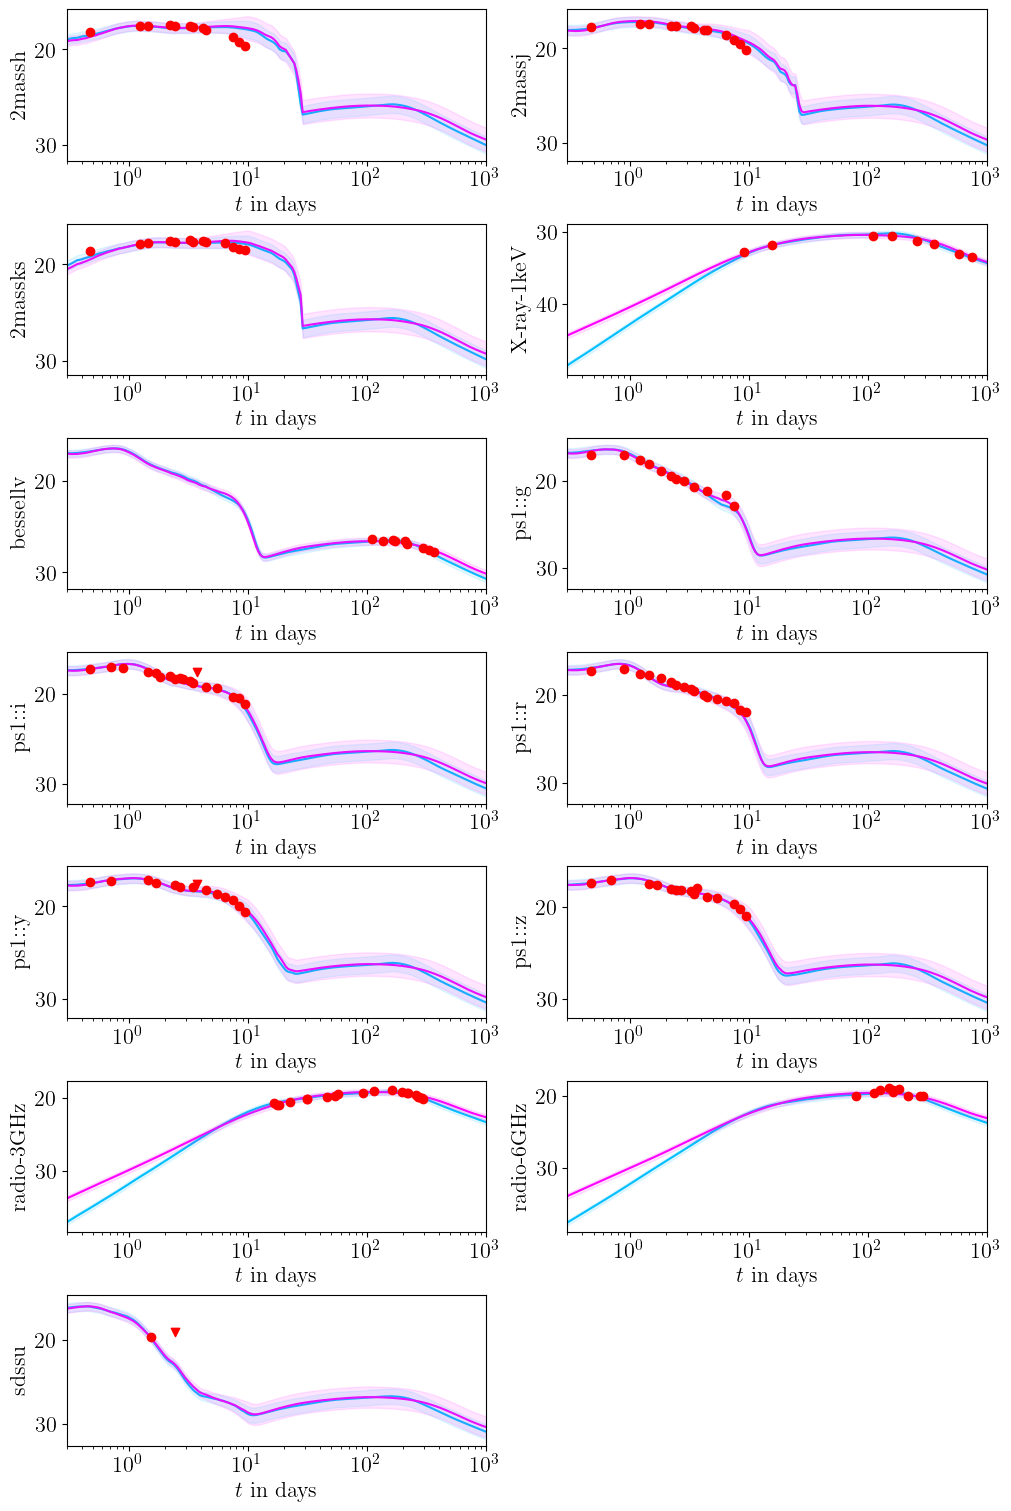

In [6]:
fig, ax = plt.subplots(7, 2, figsize=(10, 15))

for cax, filt in zip(ax.flatten(), data.keys()):
    lc_plotter_afgpy.plot_data(cax, filt, color="red")

    lc_plotter_afgpy.plot_best_fit_lc(cax, filt, color="deepskyblue")
    lc_plotter_pbag.plot_best_fit_lc(cax, filt, color="magenta")
    #lc_plotter.plot_sample_lc(cax, filt)
    lc_plotter_afgpy.plot_sys_uncertainty_band(cax, filt, systematics_file="./systematics_file.yaml", color="deepskyblue")
    lc_plotter_pbag.plot_sys_uncertainty_band(cax, filt, systematics_file="./systematics_file.yaml", color="magenta")
    
    cax.invert_yaxis()
    cax.set_xscale("log")
    cax.set_xlim((0.3, 1000))
    cax.set_xlabel("$t$ in days")
    cax.set_ylabel(filt)

ax[-1, -1].set_axis_off()
fig.show()

18:06 fiesta WARNING : Filters {'radio-6GHz', 'radio-3GHz', 'bessellv', 'X-ray-1keV'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.


18:06 fiesta WARNING : Filters {'radio-6GHz', 'radio-3GHz', 'bessellv', 'X-ray-1keV'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
18:06 fiesta WARNING : Filters {'radio-6GHz', 'radio-3GHz', 'bessellv', 'X-ray-1keV'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
18:06 fiesta WARNING : Filters {'radio-6GHz', 'radio-3GHz', 'bessellv', 'X-ray-1keV'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
18:06 fiesta WARNING : Filters {'radio-6GHz', 'radio-3GHz', 'bessellv', 'X-ray-1keV'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
18:06 fiesta WARNING : Filters {'radio-6GHz', 'radio-3GHz', 'bessellv'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.


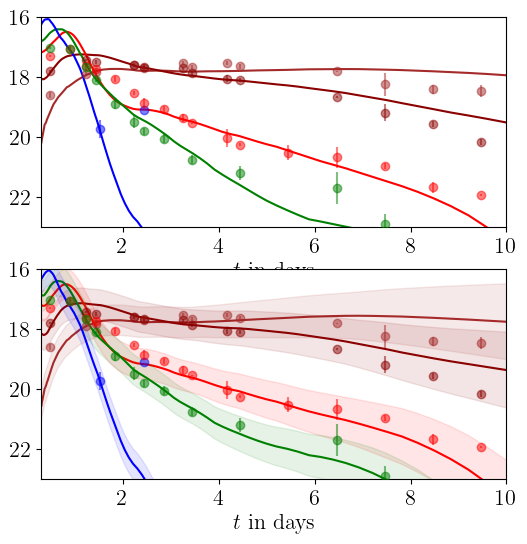

In [17]:
fig, ax = plt.subplots(2,1, figsize=(6, 6))


for filt, color in zip(["2massks", "2massj", "ps1::r", "ps1::g", "sdssu", "X-ray-1keV"], ["brown", "darkred", "red", "green", "blue", "purple"]):
    lc_plotter_afgpy.plot_data(ax[0], filt, color=color, alpha=0.5)
    lc_plotter_afgpy.plot_best_fit_lc(ax[0], filt, color=color, label=filt)

    lc_plotter_pbag.plot_data(ax[1], filt, color=color, alpha=0.5)
    lc_plotter_pbag.plot_best_fit_lc(ax[1], filt, color=color, label=filt)
    lc_plotter_pbag.plot_sys_uncertainty_band(ax[1], filt, "systematics_file.yaml", color=color)

for cax in ax:
    cax.invert_yaxis()
    cax.set_xscale("linear")
    cax.set_xlim((0.3, 10))
    cax.set_xlabel("$t$ in days")
    cax.set_ylim((23, 16))

    



18:25 fiesta WARNING : Filters {'radio-6GHz', 'bessellv', 'X-ray-1keV'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
18:25 fiesta WARNING : Filters {'radio-6GHz', 'bessellv', 'X-ray-1keV'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
18:25 fiesta WARNING : Filters {'radio-6GHz', 'radio-3GHz', 'bessellv', 'X-ray-1keV'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
18:25 fiesta WARNING : Filters {'radio-6GHz', 'radio-3GHz', 'bessellv', 'X-ray-1keV'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
18:25 fiesta WARNING : Filters {'radio-6GHz', 'radio-3GHz', 'bessellv', 'X-ray-1keV'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
18:25 fiesta WARNING : Filters {'radio-6GHz', 'radio-3GHz', 'bessellv', 'X-ray-1keV'} in

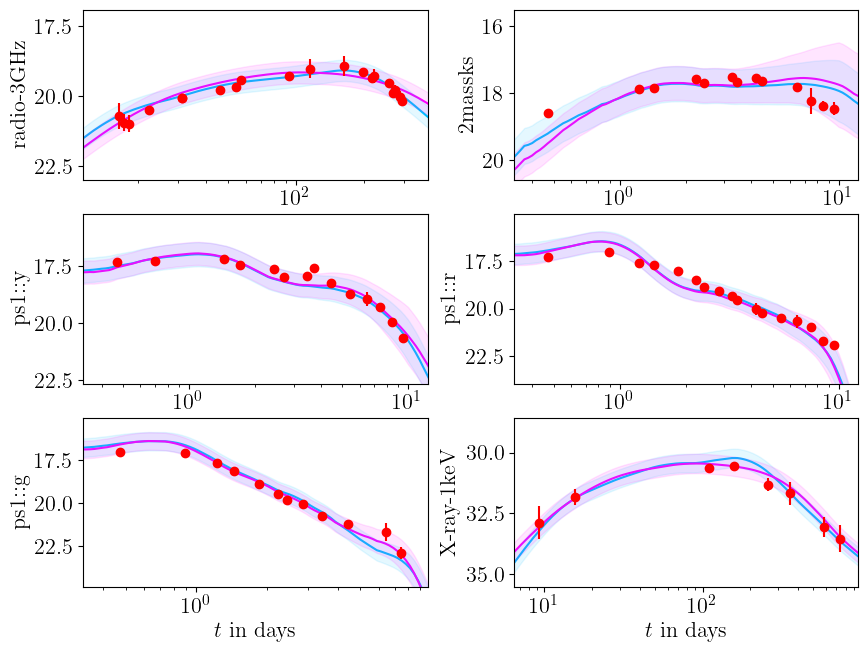

In [30]:
fig, ax = plt.subplots(3, 2, figsize=(10, 7.5))
fig.subplots_adjust(wspace=0.25)

for cax, filt in zip(ax.flatten(), ["radio-3GHz", "2massks", "ps1::y", "ps1::r", "ps1::g", "X-ray-1keV"]):
    lc_plotter_afgpy.plot_data(cax, filt, color="red")

    lc_plotter_afgpy.plot_best_fit_lc(cax, filt, color="deepskyblue")
    lc_plotter_pbag.plot_best_fit_lc(cax, filt, color="magenta")
    #lc_plotter.plot_sample_lc(cax, filt)
    lc_plotter_afgpy.plot_sys_uncertainty_band(cax, filt, systematics_file="./systematics_file.yaml", color="deepskyblue")
    lc_plotter_pbag.plot_sys_uncertainty_band(cax, filt, systematics_file="./systematics_file.yaml", color="magenta")
    
    cax.invert_yaxis()
    cax.set_xscale("log")
    cax.set_xlabel("$t$ in days")
    cax.set_ylabel(filt)

    cax.set_ylim(data[filt][:,1].max()+2, data[filt][:,1].min()-2)
    cax.set_xlim((data[filt][:,0]-trigger_time).min()*0.7, (data[filt][:,0]-trigger_time).max()*1.3)


fig.savefig("lightcurves_GRB170817A.pdf", dpi=250, bbox_inches="tight")

In [67]:
import json

with open("./Bu2023/Constraints170817_bestfit_params.json") as f:
    mag_Bu2023 = json.load(f)["Magnitudes"]

/tmp/ipykernel_958/755203266.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


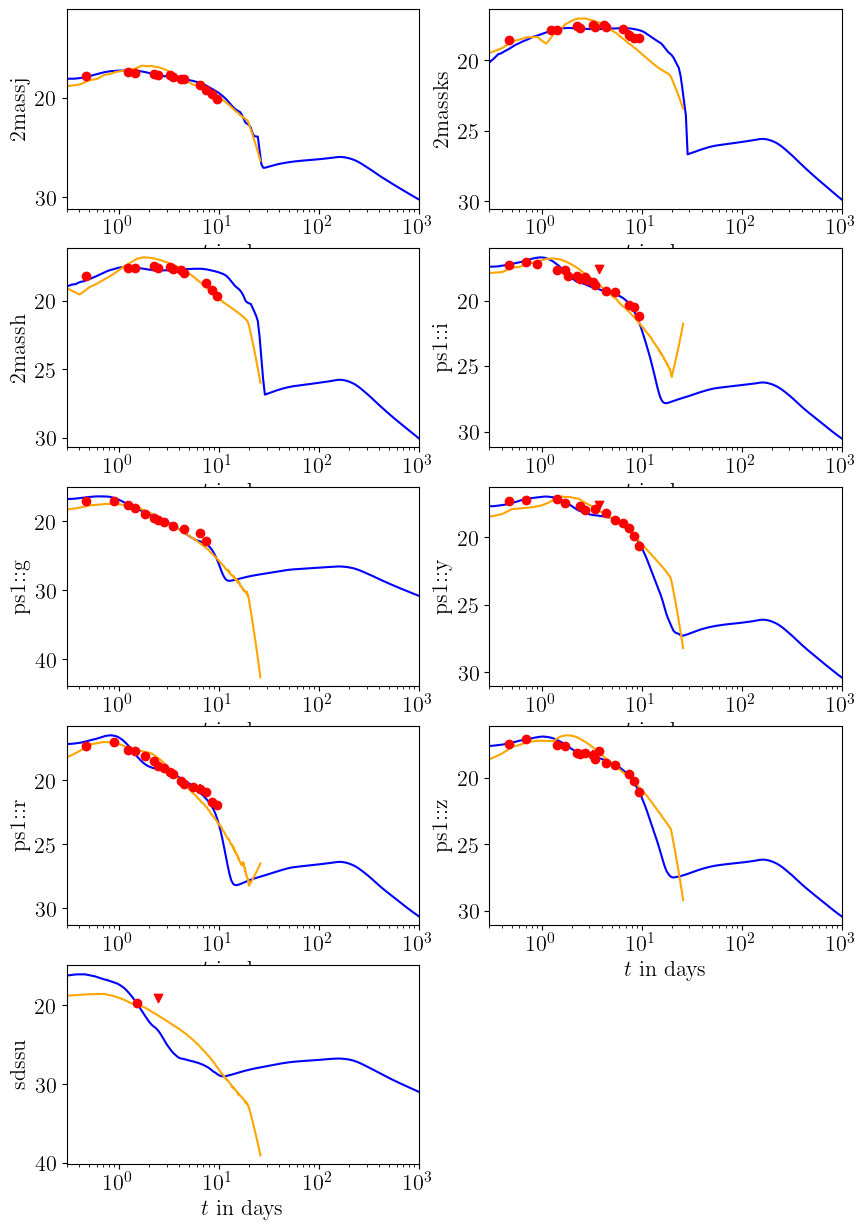

In [73]:
fig, ax = plt.subplots(5, 2, figsize=(10, 15))

for cax, filt in zip(ax.flatten(), ["2massj", "2massks", "2massh", "ps1::i", "ps1::g", "ps1::y", "ps1::r", "ps1::z", "sdssu"]):
    lc_plotter.plot_data(cax, filt)
    lc_plotter.plot_best_fit_lc(cax, filt)
    #lc_plotter.plot_sample_lc(cax, filt)
    #lc_plotter.plot_sys_uncertainty_band(cax, filt, systematics_file="./systematics_file.yaml", zorder=0)
    
    try:
       cax.plot(mag_Bu2023["bestfit_sample_times"], mag_Bu2023[filt.replace("::", "__")], color="orange")
    except:
        pass
    
    cax.invert_yaxis()
    cax.set_xscale("log")
    cax.set_xlim((0.3, 1000))
    cax.set_xlabel("$t$ in days")
    cax.set_ylabel(filt)

ax[-1, -1].set_axis_off()
fig.show()

18:46 fiesta WARNING : Filters {'radio-6GHz', 'X-ray-1keV', 'bessellv'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
18:46 fiesta WARNING : Filters {'radio-6GHz', 'X-ray-1keV', 'radio-3GHz', 'bessellv'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
18:46 fiesta WARNING : Filters {'radio-6GHz', 'X-ray-1keV', 'radio-3GHz', 'bessellv'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
18:46 fiesta WARNING : Filters {'radio-6GHz', 'X-ray-1keV', 'radio-3GHz', 'bessellv'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
18:46 fiesta WARNING : Filters {'radio-6GHz', 'radio-3GHz', 'bessellv'} in systematics file are not part of the lightcurve data. Removing them from the sys. error group GRB.
/tmp/ipykernel_11204/2730300019.py:15: UserWarning: FigureCanvasAgg is non-interactive, 

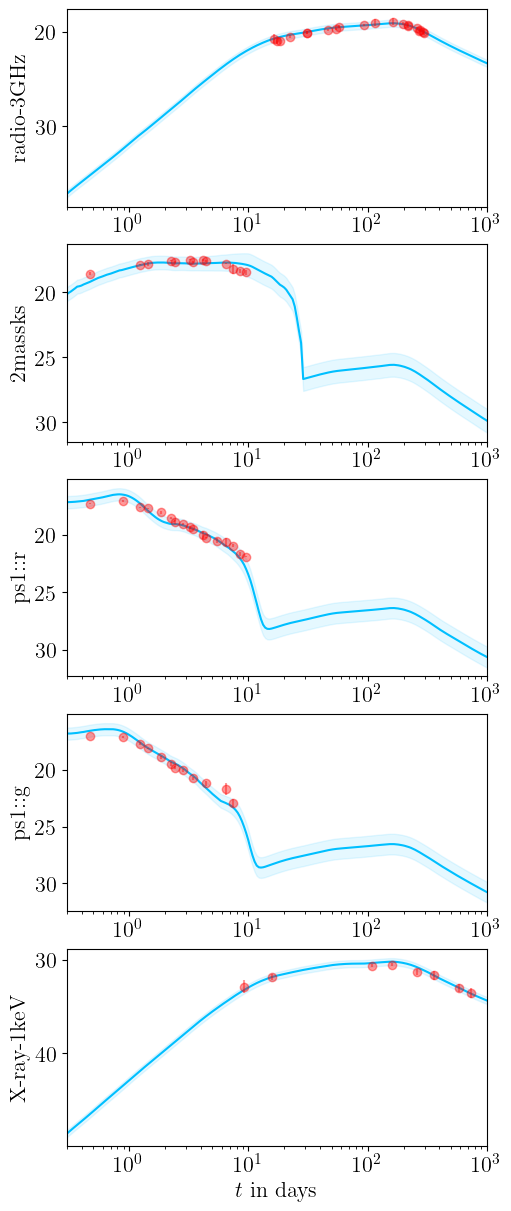

In [6]:
fig, ax = plt.subplots(5, 1, figsize=(5, 12))

for cax, filt in zip(ax, ["radio-3GHz", "2massks", "ps1::r", "ps1::g", "X-ray-1keV"]):
    lc_plotter_afgpy.plot_data(cax, filt, color="red", alpha=0.4)
    lc_plotter_afgpy.plot_best_fit_lc(cax, filt, color="deepskyblue")
    #lc_plotter.plot_sample_lc(cax, filt)
    lc_plotter_afgpy.plot_sys_uncertainty_band(cax, filt, systematics_file="./systematics_file.yaml", zorder=0, color="deepskyblue")

    cax.invert_yaxis()
    cax.set_xscale("log")
    cax.set_xlim((0.3, 1000))
    cax.set_ylabel(filt)

ax[-1].set_xlabel("$t$ in days")
fig.show()

In [11]:
np.savetxt("times.dat", lc_plotter_afgpy.t_best_fit)

In [12]:
np.savez("lightcurves.npz", **lc_plotter_afgpy.best_fit_lc)